<a href="https://colab.research.google.com/github/Hamid-Mofidi/PNP/blob/main/Bifurcation_of_lambda/bif_of_lam_new4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code implements a bifurcation analysis of the flux ratio to investigate the influence of fixed charges on ionic transport phenomena.

In Python, `root` is a function from the `scipy.optimize` module that is used to find the roots of a system of nonlinear equations. It is a general-purpose function that can be used to solve various types of equations.

The `root` function has several optional parameters, including `x0` (initial guess) and `method` (solver method). The `method` parameter specifies the algorithm to be used for solving the equations. The default value for `method` is 'hybr'.

'hybr' is short for "hybrid" and it refers to a solver that combines a modified Powell's method with a dogleg trust-region method. This method is suitable for systems of equations where the Jacobian matrix is not provided or is approximated numerically. It is a good choice for general-purpose root finding problems.

Other available options for the `method` parameter in `root` include:

- 'lm': Levenberg-Marquardt algorithm, suitable for least-squares problems.
- 'broyden1' and 'broyden2': Broyden's first and second methods, respectively, for solving systems of equations.
- 'anderson': Anderson's mixing method, suitable for solving systems of equations with good initial guesses.
- 'linearmixing': Linear mixing method, suitable for solving systems of linear equations.

The choice of the solver method depends on the specific characteristics of the problem you are trying to solve. Some methods may be more efficient or accurate for certain types of equations or initial conditions. It is recommended to consult the documentation of `scipy.optimize.root` or the scipy documentation for more details on the available methods and their best use cases.

In [1]:
from scipy.optimize import root
import numpy as np
import matplotlib.pyplot as plt
fixed_r = 2
k = 1 # k=1: bif of lambda_1,  k=2: bif of lambda_2

In [2]:
def equations(x):
    A, I, V, l = x

    # k = 1
    r =  fixed_r
    eps = 1e-15 #  a small number

    sqA    = np.sqrt(1+A**2)
    sqB    = np.sqrt(1+(l-A+r)**2) #assume that alpha=1/3, beta=2/3
    logAB  = np.log(np.maximum( (l-A+r)*(sqA-1), eps)/np.maximum( A*(sqB-1), eps) )
    rho    = (A-l)**2 + (sqA - sqB)*(A-l)
    sigma  = l/r
    logSBA = np.log(np.maximum( sigma*(l-A+r) , eps)/ np.maximum(A, eps) ) # not a real number
    siglog = 3*sigma*np.log( np.maximum( sigma, eps) )/(l*(sigma-1))

    numI1   = (( (-1)**(k+1) )*siglog) * (A-l)**2
    numI2   = (logAB - ((-1)**k) * np.log( np.maximum(sigma, eps) ))*(A-l+eps)
    gamma1  = 1/(I-(A-l) * sqA)
    gamma2  = 1/(I-(A-l) * sqB)
    M       = I * (gamma2 - gamma1)+ rho/I
    ABGamma = A * gamma1 + (l-A+r) * gamma2
    ABGammaR= (1/A) * gamma1 + (1/(l-A+r)) * gamma2
    G41     = ( 1- (A-l)*ABGamma )*( logSBA + (A-l) * siglog )
    G42     = ( 1- (A-l)*ABGamma )* M
    G43     = ( I+ ( ((-1)**k) * (A-l) ) ) * siglog * M/(A-l)
    GR      =( ( I**2-(A-l)**2 )/(A-l) ) * M * ABGammaR



    f1 = rho - (I* ( np.log( np.maximum( I-(A-l)*sqB, eps) /np.maximum( I-(A-l)*sqA , eps) )  ))
    f2 = V - logAB + ((I*logSBA-rho)/(A-l))
    f3 = I - ( (numI1 + numI2+rho)/(logSBA + siglog*(A-l))  )
    f4 = G41 - G42 + G43 - GR

    return [f1, f2, f3, f4]



In [3]:
# set a range of initial values
A_range = np.linspace(0.01, 10, 20)
I_range = np.linspace(-60, 60, 20)
V_range = np.linspace(-80, 80, 20)
l_range = np.linspace(0.01, 10, 20)

r = fixed_r
print(r)

# Create a boolean mask for the constraint
# The resulting arrays for A_range, I_range, V_range, and L_range
# will only contain values that satisfy the constraint.
# Calculate Am
Am = l_range + r

# Calculate the expressions
expression1 = (A_range - l_range) * np.sqrt(1 + A_range**2)
expression2 = (A_range - l_range) * np.sqrt(1 + (l_range - A_range + r)**2)

# Calculate the maximum and minimum expressions
max_expression = np.maximum(expression1, expression2)
min_expression = np.minimum(expression1, expression2)

eps = 1e-15 #  a small number
mask = ( (I_range > max_expression) | (I_range < min_expression) ) & (np.abs(I_range) > eps) & (A_range > 0) & (A_range <= Am) & (np.abs(l_range-r) > eps)

# Apply the mask to all arrays
A_range = A_range[mask]
I_range = I_range[mask]
V_range = V_range[mask]
l_range = l_range[mask]

# initialize arrays to store solutions
A_sol = []
I_sol = []
V_sol = []
l_sol = []

import time

# Start the timer
start_time = time.time()

# loop through all combinations of initial values
for a in A_range:
    for i in I_range:
        for v in V_range:
            for ll in l_range:
                x0 = [a, i, v, ll]
                sol = root(equations, x0, method='hybr')
                # Calculate lmd1 and lmd2

                if sol.success: # check if solution was found
                    # check if solution satisfies the mask
                    expression12 = (sol.x[0] - sol.x[3]) * np.sqrt(1 + sol.x[0]**2)
                    expression22 = (sol.x[0] - sol.x[3]) * np.sqrt(1 + (sol.x[3] - sol.x[0] + r)**2)
                    max_expression2 = np.maximum(expression12, expression22)
                    min_expression2 = np.minimum(expression12, expression22)

                    lmd1_sol = 3*(sol.x[3] - sol.x[0] + sol.x[1]) * \
                     (np.log(np.maximum(sol.x[3]/r, 1e-15))) / \
                     ((sol.x[3] - r) * (sol.x[2] +  np.log(sol.x[3]) - np.log(r)  ))

                    lmd2_sol = 3*(sol.x[3] - sol.x[0] - sol.x[1]) * \
                    (np.log(sol.x[3]) - np.log(r)) / \
                       ((sol.x[3] - r) * (-sol.x[2] + np.log(sol.x[3]) - np.log(r)  ))

                    mask2 =  ( (sol.x[1] > max_expression2) | (sol.x[1] < min_expression2) ) & (np.abs(sol.x[1]) > eps) &  (np.abs(sol.x[3]-r) > eps)  & (sol.x[0] >= 0) & (sol.x[0] <= sol.x[3] + r)  &(lmd1_sol<=lmd2_sol)
                    if np.all(mask2): # only append if all elements of mask are True
                      A_sol = np.append(A_sol, sol.x[0])
                      I_sol = np.append(I_sol, sol.x[1])
                      V_sol = np.append(V_sol, sol.x[2])
                      l_sol = np.append(l_sol, sol.x[3])

2


<ipython-input-2-26c7e9bf3e77>:25: RuntimeWarning: invalid value encountered in double_scalars
  G43     = ( I+ ( ((-1)**k) * (A-l) ) ) * siglog * M/(A-l)
<ipython-input-2-26c7e9bf3e77>:26: RuntimeWarning: divide by zero encountered in double_scalars
  GR      =( ( I**2-(A-l)**2 )/(A-l) ) * M * ABGammaR
<ipython-input-2-26c7e9bf3e77>:26: RuntimeWarning: invalid value encountered in double_scalars
  GR      =( ( I**2-(A-l)**2 )/(A-l) ) * M * ABGammaR
<ipython-input-2-26c7e9bf3e77>:31: RuntimeWarning: invalid value encountered in double_scalars
  f2 = V - logAB + ((I*logSBA-rho)/(A-l))
<ipython-input-2-26c7e9bf3e77>:32: RuntimeWarning: divide by zero encountered in double_scalars
  f3 = I - ( (numI1 + numI2+rho)/(logSBA + siglog*(A-l))  )
<ipython-input-3-c6754ab53736>:62: RuntimeWarning: invalid value encountered in log
  ((sol.x[3] - r) * (sol.x[2] +  np.log(sol.x[3]) - np.log(r)  ))
<ipython-input-3-c6754ab53736>:65: RuntimeWarning: invalid value encountered in log
  (np.log(sol.x[3])

In [4]:
print('r is ', r)
print('k is ', k)

r is  2
k is  1


In [5]:
# Calculate the time passing
end_time = time.time()
time_passing = end_time - start_time
print("Time passing:", time_passing, "seconds")

Time passing: 1477.9448964595795 seconds


In [6]:

print(np.shape(A_sol))
print('A[0:10] = ', A_sol[0:10])
print('min(A) =',np.min(A_sol))
print('max(A) =',np.max(A_sol))
print('The second max of A is =',np.partition(A_sol,-50)[-50:-40])
print('type of A is', type(A_sol))

print(np.shape(l_sol))
print('l[0:10] = ', l_sol[0:10])
print('min(l) =',np.min(l_sol))
print('max(l) =',np.max(l_sol))
print('The second max of l is =',np.partition(l_sol,-550)[-550:-520])
print('type of l is', type(l_sol))

print(np.shape(V_sol))
print('V[0:10] = ', V_sol[0:10])
print('min(V) =',np.min(V_sol))
print('max(V) =',np.max(V_sol))
print('The second max of V is =',np.partition(V_sol,-50)[-50:-40])
print('type of V is', type(V_sol))

print(np.shape(I_sol))
print('I[0:10] = ', I_sol[0:10])
print('min(I) =',np.min(I_sol))
print('max(I) =',np.max(I_sol))
print('The second max of I is =',np.partition(I_sol,-50)[-50:-40])




(37571,)
A[0:10] =  [1.99895034 2.         2.00234419 2.20385176 2.00050279 0.46455838
 1.60884383 1.88629978 2.         1.9517683 ]
min(A) = 0.40334674337441745
max(A) = 90.273836612162
The second max of A is = [90.2731457  90.27314875 90.27314944 90.27328006 90.27317338 90.27325423
 90.27324633 90.27318036 90.2731501  90.27323102]
type of A is <class 'numpy.ndarray'>
(37571,)
l[0:10] =  [1.99895034 2.00000001 2.00234418 2.20385179 2.0005028  0.46455838
 1.60884383 1.88629975 2.00000002 1.95176832]
min(l) = 0.07911307262283462
max(l) = 134.7453660578377
The second max of l is = [134.73764466 134.73764491 134.73764966 134.73766923 134.73765473
 134.73766712 134.73765921 134.737664   134.73765248 134.73765757
 134.73765499 134.73765716 134.73765371 134.73766683 134.73766866
 134.73766937 134.7376916  134.73769375 134.73769475 134.73769564
 134.73768052 134.73768178 134.73769092 134.73768097 134.73768045
 134.73769269 134.73768875 134.73768672 134.73769776 134.73767802]
type of l is <cla

In [7]:
#import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D

#fig = plt.figure(figsize=(8, 6))
#ax = fig.add_subplot(111, projection='3d')

#ax.scatter(l_sol, V_sol, I_sol, c='red', s=5)
#ax.set_xlabel('l')
#ax.set_ylabel('V')
#ax.set_zlabel('I(current)')
#ax.set_xlim(0, 6)
#ax.set_ylim(-20, 50)
#ax.set_zlim(ymin, ymax)

#plt.show()


In [8]:
r = fixed_r
print('r is ', r)
print('k is ', k)

# Calculate lmd1 and lmd2
lmd1 = 3*(l_sol - A_sol + I_sol) * \
       (np.log(np.maximum(l_sol/r, 1e-15))) / \
       ((l_sol - r) * ( V_sol + np.log(l_sol) - np.log(r)   ))

lmd2 = 3*(l_sol - A_sol - I_sol) * \
       (np.log(np.maximum(l_sol/r, +1e-15))) / \
       ((l_sol - r) * (-V_sol + np.log(l_sol) - np.log(r)   ))

J1 = (l_sol - A_sol + I_sol) /2
J2 = (l_sol - A_sol - I_sol) /2

# Generate t vector
t = np.arange(len(lmd1))

r is  2
k is  1


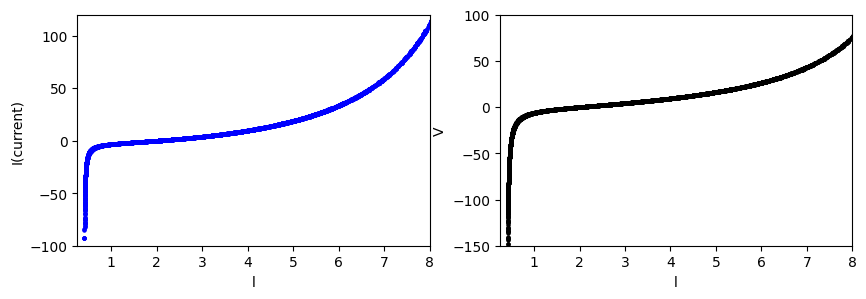

In [9]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)
axs[0, 0].scatter(l_sol, I_sol, s=5, c='blue')
axs[0, 0].set_xlabel('l')
axs[0, 0].set_ylabel('I(current)')
axs[0,0].set_xlim(0.25, 8)  # Adjust the x-axis limits
axs[0,0].set_ylim(-100, 120)  # Adjust the y-axis limits

axs[0, 1].scatter(l_sol, V_sol, s=5, c='black')
axs[0, 1].set_xlabel('l')
axs[0, 1].set_ylabel('V')
axs[0,1].set_xlim(0.25, 8)  # Adjust the x-axis limits
axs[0,1].set_ylim(-150, 100)  # Adjust the y-axis limits


plt.show()

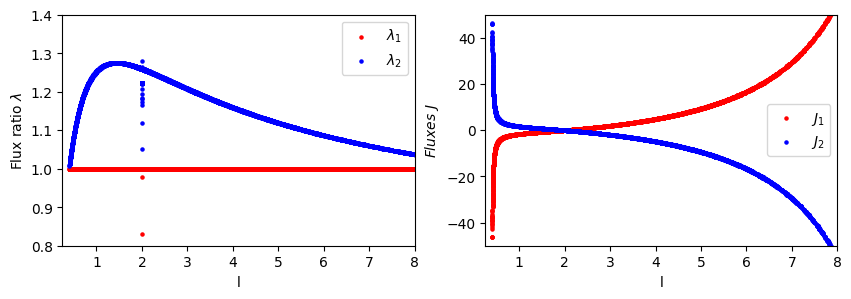

In [10]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)

axs[0, 0].scatter(l_sol, lmd1, label='$\lambda_1$',s=5, color='red')
axs[0, 0].scatter(l_sol, lmd2, label='$\lambda_2$', s=5, color='blue')
axs[0, 0].set_xlabel('l')
axs[0, 0].set_ylabel('Flux ratio $\lambda$')
axs[0, 0].legend()
axs[0, 0].set_xlim(0.25, 8)  # Adjust the x-axis limits
axs[0, 0].set_ylim(0.8, 1.4)  # Adjust the y-axis limits

axs[0, 1].scatter(l_sol, J1, label='$J_1$', s=5, color='red')
axs[0, 1].scatter(l_sol, J2, label='$J_2$', s=5, color='blue')
axs[0, 1].set_xlabel('l')
axs[0, 1].set_ylabel('$Fluxes~J$')
axs[0, 1].legend()
axs[0, 1].set_xlim(.25, 8)  # Adjust the x-axis limits
axs[0, 1].set_ylim(-50, 50)  # Adjust the y-axis limits


plt.show()

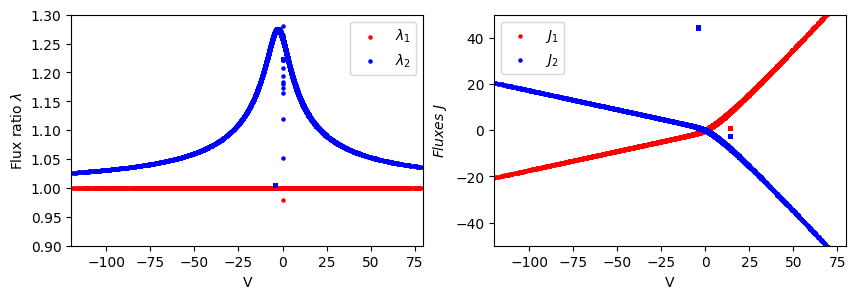

In [11]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)

axs[0, 0].scatter(V_sol, lmd1, label='$\lambda_1$',s=5, color='red')
axs[0, 0].scatter(V_sol, lmd2, label='$\lambda_2$', s=5, color='blue')
axs[0, 0].set_xlabel('V')
axs[0, 0].set_ylabel('Flux ratio $\lambda$')
axs[0, 0].legend()
axs[0, 0].set_xlim(-120, 80)  # Adjust the x-axis limits
axs[0, 0].set_ylim(0.9, 1.3)  # Adjust the y-axis limits

axs[0, 1].scatter(V_sol, J1, label='$J_1$', s=5, color='red')
axs[0, 1].scatter(V_sol, J2, label='$J_2$', s=5, color='blue')
axs[0, 1].set_xlabel('V')
axs[0, 1].set_ylabel('$Fluxes~J$')
axs[0, 1].legend()
axs[0, 1].set_xlim(-120, 80)  # Adjust the x-axis limits
axs[0, 1].set_ylim(-50, 50)  # Adjust the y-axis limits


plt.show()

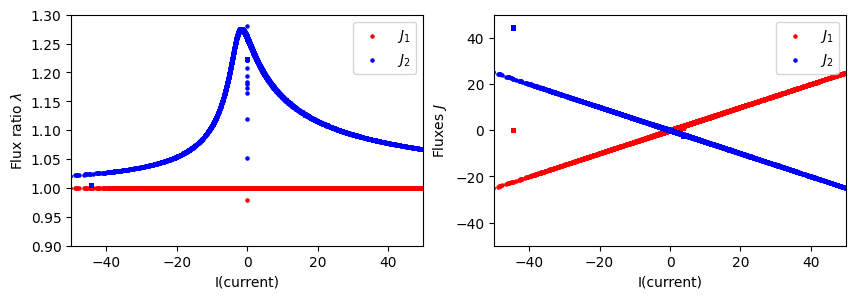

In [12]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)

axs[0, 0].scatter(I_sol, lmd1, label='$J_1$',s=5, color='red')
axs[0, 0].scatter(I_sol, lmd2, label='$J_2$', s=5, color='blue')
axs[0, 0].set_xlabel('I(current)')
axs[0, 0].set_ylabel('Flux ratio $\lambda$')
axs[0, 0].legend()
axs[0, 0].set_xlim(-50, 50)  # Adjust the x-axis limits
axs[0, 0].set_ylim(.9, 1.3)  # Adjust the y-axis limits

axs[0, 1].scatter(I_sol, J1, label='$J_1$', s=5, color='red')
axs[0, 1].scatter(I_sol, J2, label='$J_2$', s=5, color='blue')
axs[0, 1].set_xlabel('I(current)')
axs[0, 1].set_ylabel('Fluxes $J$')
axs[0, 1].legend()
axs[0, 1].set_xlim(-50, 50)  # Adjust the x-axis limits
axs[0, 1].set_ylim(-50, 50)  # Adjust the y-axis limits

plt.show()

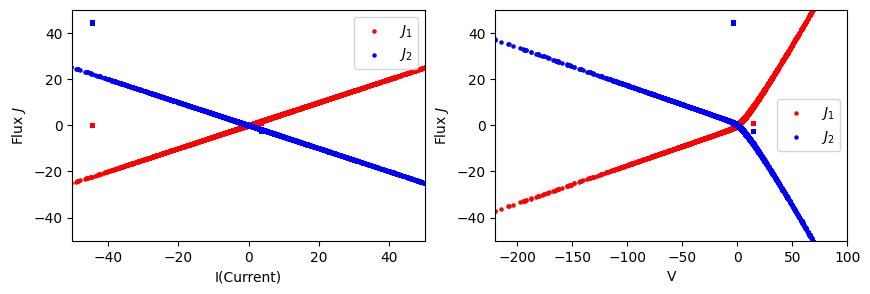

In [16]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)

axs[0, 0].scatter(I_sol, J1, label='$J_1$',s=5, color='red')
axs[0, 0].scatter(I_sol, J2, label='$J_2$', s=5, color='blue')
axs[0, 0].set_xlabel('I(Current)')
axs[0, 0].set_ylabel('Flux $J$')
axs[0, 0].legend()
axs[0, 0].set_xlim(-50, 50)  # Adjust the x-axis limits
axs[0, 0].set_ylim(-50, 50)  # Adjust the y-axis limits

axs[0, 1].scatter(V_sol, J1, label='$J_1$', s=5, color='red')
axs[0, 1].scatter(V_sol, J2, label='$J_2$', s=5, color='blue')
axs[0, 1].set_xlabel('V')
axs[0, 1].set_ylabel('Flux $J$')
axs[0, 1].legend()
axs[0, 1].set_xlim(-220, 100)  # Adjust the x-axis limits
axs[0, 1].set_ylim(-50, 50)  # Adjust the y-axis limits

plt.show()

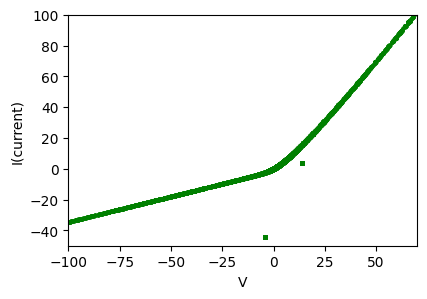

In [20]:
# plot the solutions
fig, axs = plt.subplots(1, 1, figsize=(4.5, 3), squeeze=False)

axs[0, 0].scatter(V_sol, I_sol, s=5, c='green')
axs[0, 0].set_xlabel('V')
axs[0, 0].set_ylabel('I(current)')
axs[0, 0].set_xlim(-100, 70)  # Adjust the x-axis limits
axs[0, 0].set_ylim(-50, 100)  # Adjust the y-axis limits
# Plot lmd1 and lmd2 using scatter plots

plt.show()

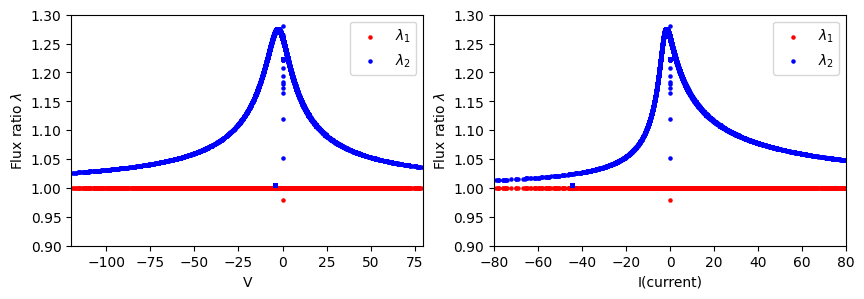

In [15]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)

axs[0, 0].scatter(V_sol, lmd1, label='$\lambda_1$', s=5, color='red')
axs[0, 0].scatter(V_sol, lmd2, label='$\lambda_2$', s=5, color='blue')
axs[0, 0].set_xlabel('V')
axs[0, 0].set_ylabel('Flux ratio $\lambda$')
axs[0, 0].legend()
axs[0, 0].set_xlim(-120, 80)  # Adjust the x-axis limits
axs[0, 0].set_ylim(.9, 1.3)  # Adjust the y-axis limits

axs[0, 1].scatter(I_sol, lmd1, label='$\lambda_1$', s=5, color='red')
axs[0, 1].scatter(I_sol, lmd2, label='$\lambda_2$', s=5, color='blue')
axs[0, 1].set_xlabel('I(current)')
axs[0, 1].set_ylabel('Flux ratio $\lambda$')
axs[0, 1].legend()
axs[0, 1].set_xlim(-80, 80)  # Adjust the x-axis limits
axs[0, 1].set_ylim(.9, 1.3)  # Adjust the y-axis limits
plt.show()